In [1]:
## research question
## Given a claim and a topic, can we figure out if the claim is for or against the topic?

import numpy as np
import pandas as pd
import string
import nltk
from sklearn.linear_model import LogisticRegression
from utils import MyTokenizer, MySentences, MeanEmbeddingVectorizer, evaluate_train
import warnings
warnings.filterwarnings("ignore")

In [2]:
claimDF = pd.read_csv("IBM_EACL-2017.v1/claim_stance_dataset_v1.csv")

In [3]:
# 2394
# create dataset
test = claimDF[['claims.stance', 'claims.claimCorrectedText', 'topicText']]

In [4]:
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
from nltk.sentiment import SentimentAnalyzer
from nltk.sentiment.util import *
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [5]:
sid = SentimentIntensityAnalyzer()
ss = sid.polarity_scores("HI BEN")

In [6]:
print ss

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}


In [7]:
mean_embedding_vectorizer = MeanEmbeddingVectorizer(None)

test['claim_token'] = test['claims.claimCorrectedText'].apply(lambda x: nltk.word_tokenize(x.lower()))
test['claim_sentiment_compound']  = test['claim_token'].apply(lambda x: sid.polarity_scores(" ".join(x))['compound'])
test['claim_sentiment_neg']  = test['claim_token'].apply(lambda x: sid.polarity_scores(" ".join(x))['neg'])
test['claim_sentiment_neu']  = test['claim_token'].apply(lambda x: sid.polarity_scores(" ".join(x))['neu'])
test['claim_sentiment_pos']  = test['claim_token'].apply(lambda x: sid.polarity_scores(" ".join(x))['pos'])

test['topic_token'] = test['topicText'].apply(lambda x: nltk.word_tokenize(x.lower()))
test['topic_sentiment_compound']  = test['topic_token'].apply(lambda x: sid.polarity_scores(" ".join(x))['compound'])
test['topic_sentiment_neg']  = test['topic_token'].apply(lambda x: sid.polarity_scores(" ".join(x))['neg'])
test['topic_sentiment_neu']  = test['topic_token'].apply(lambda x: sid.polarity_scores(" ".join(x))['neu'])
test['topic_sentiment_pos']  = test['topic_token'].apply(lambda x: sid.polarity_scores(" ".join(x))['pos'])

test['stance'] = test['claims.stance'].apply(lambda x: 0 if x == 'PRO' else 1)

In [8]:
test['final_embedding'] = test.apply(lambda x: [
    x['claim_sentiment_compound'],
    x['claim_sentiment_neg'],
    x['claim_sentiment_neu'],
    x['claim_sentiment_pos'],
    x['topic_sentiment_compound'],
    x['topic_sentiment_neg'],
    x['topic_sentiment_neu'],
    x['topic_sentiment_pos'],
], axis=1)


Train Log loss: 0.708648592192
Train Accuracy: 0.499164578112


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

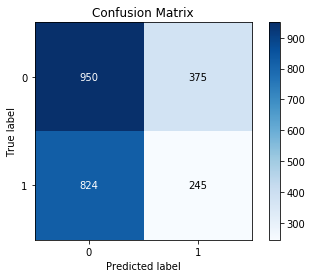

In [9]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

X = np.vstack(test['final_embedding'].as_matrix())
y = test['stance'].values.ravel()

evaluate_train(X, y, LogisticRegression())

In [19]:
from sklearn.metrics.pairwise import cosine_similarity
def cossim(row):
    #print row
    return [cosine_similarity(
        np.array([row['claim_sentiment_neg'], row['claim_sentiment_neu'], row['claim_sentiment_pos']]).reshape(1, -1), 
        np.array([row['topic_sentiment_neg'], row['claim_sentiment_neu'], row['topic_sentiment_pos']]).reshape(1, -1))]
    

test['similarity'] = test.apply(lambda x: cossim(x), axis=1)
test['similarity'] = test['similarity'].apply(lambda x: x[0][0][0])

Train Log loss: 0.687350623361
Train Accuracy: 0.552631578947


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s finished


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

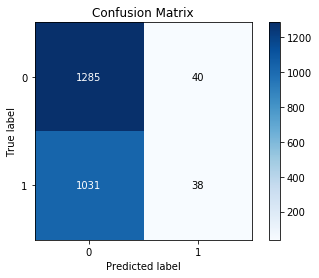

In [20]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import StratifiedKFold

X = np.vstack(test['similarity'].as_matrix())
y = test['stance'].values.ravel()

evaluate_train(X, y, LogisticRegression())